In [35]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
warnings.filterwarnings("ignore")

In [2]:
paths = os.listdir(path='F:\\')
bb_path = list(filter(lambda file: file.endswith('BB.csv'), paths))[0]
hh_path = list(filter(lambda file: file.endswith('HH.csv'), paths))[0]
print(bb_path, hh_path)

SVO-AER_2018-01-01--2019-12-31BB.csv SVO-AER_2018-01-01--2019-12-31HH.csv


In [9]:
%%time
use_cols = ['DD', 'SSCL1', 'PASS_BK', 'DTD']
dates = ['DD']
hh = pd.read_csv('F:\\' + hh_path, delimiter=';', parse_dates=dates, usecols=use_cols)
hh.dropna(how='any', axis=0, inplace=True)
hh.drop_duplicates(inplace=True, ignore_index=True)
hh[['PASS_BK', 'DTD']] = hh[['PASS_BK', 'DTD']].astype(int)
hh = hh[hh['DTD'] <= 60]
hh['weekend'] = (hh['DD'].dt.dayofweek > 4).astype(int) # 1 - выходной / 0 - рабочий
hh['dayOfWeek'] = hh['DD'].dt.dayofweek # дни недели
apr_days, may_days, dec_days, jan_days = [29, 30], [1, 6, 7, 8, 9], [29, 30, 31], [1, 2, 3, 4, 5, 6, 7, 8]
april, may, december, january = 4, 5, 12, 1
hh['holidays'] = \
((hh['DD'].dt.day.isin(apr_days)) & (hh['DD'].dt.month == april)      | # праздник весны и труда
   (hh['DD'].dt.day.isin(may_days)) & (hh['DD'].dt.month == may)      | # 9 мая
   (hh['DD'].dt.day.isin(dec_days)) & (hh['DD'].dt.month == december) |  # предновогодние дни
   (hh['DD'].dt.day.isin(jan_days)) & (hh['DD'].dt.month == january))    # новогодние дни
hh['holidays'] = hh['holidays'].astype(int)
hh['DTD'] = -hh['DTD']
display(hh.head())

,DD,SSCL1,PASS_BK,DTD,weekend,dayOfWeek,holidays
0,2018-01-01,C,12,1,0,0,1
1,2018-01-01,C,0,1,0,0,1
2,2018-01-01,C,3,1,0,0,1
3,2018-01-01,C,5,1,0,0,1
4,2018-01-01,Y,0,1,0,0,1


Wall time: 3min 24s


In [93]:
def get_time_of_day(elem: pd.Timedelta) -> int:
    """Замена времени на время суток"""
    if pd.Timedelta('5:00:00') <= elem <= pd.Timedelta('11:59:00'):
        return 0 # утро
    elif pd.Timedelta('12:00:00') <= elem <= pd.Timedelta('16:59:00'):
        return 1 # день
    elif pd.Timedelta('17:00:00') <= elem <= pd.Timedelta('21:59:00'):
        return 2 # вечер
    return 3     # ночь

use_cols = ('FLTDAT', 'FLTTIME')
dates = ['FLTDAT']
dtypes = {'TARIF_RUB': 'float16'}
bb = pd.read_csv('F:\\' + bb_path, delimiter=';', dtype=dtypes, parse_dates=dates, usecols=use_cols)
bb = bb.dropna(how='any', axis=0)
bb['FLTTIME'] = pd.to_timedelta(bb['FLTTIME'])
bb['TOD'] = bb['FLTTIME'].apply(get_time_of_day)
bb = bb.rename(columns={'FLTDAT': 'DD'})
bb.dropna(how='any', axis=0, inplace=True)
bb.drop_duplicates(inplace=True, ignore_index=True)
bb.head()

,DD,FLTTIME,TOD
0,2018-01-21,0 days 13:35:00,1
1,2018-01-10,0 days 09:10:00,0
2,2018-01-11,0 days 09:10:00,0
3,2018-01-26,0 days 17:35:00,2
4,2018-01-06,0 days 09:10:00,0


# Распределение бронирования билетов по выходным/будним дням

In [15]:
def mean_sums(sub_dataframe: pd.DataFrame) -> pd.Series:
    """Подсчёт усреднённого количества бронирований для всех дней до вылета"""
    dtds = {dtd: [] for dtd in sub_dataframe['DTD'].unique()}
    for date in sub_dataframe['DD'].unique():
        sub = sub_dataframe[sub_dataframe['DD'] == date]
        sub = sub.groupby(by=['DTD'])['PASS_BK'].sum().to_dict()
        for key in sub:
            dtds[key].append(sub[key])
    return pd.Series(dict(map(lambda k_v: (k_v[0],  np.mean(k_v[1])), dtds.items())))

C, Y = 'C', 'Y'

In [115]:
weekdays = hh[hh['weekend'] == 0]
weekends = hh[hh['weekend'] == 1]
weekdays_C = mean_sums(weekdays[weekdays['SSCL1'] == C][['DD', 'PASS_BK', 'DTD']])
weekdays_Y = mean_sums(weekdays[weekdays['SSCL1'] == Y][['DD', 'PASS_BK', 'DTD']])
weekends_C = mean_sums(weekends[weekends['SSCL1'] == C][['DD', 'PASS_BK', 'DTD']])
weekends_Y = mean_sums(weekends[weekends['SSCL1'] == Y][['DD', 'PASS_BK', 'DTD']])

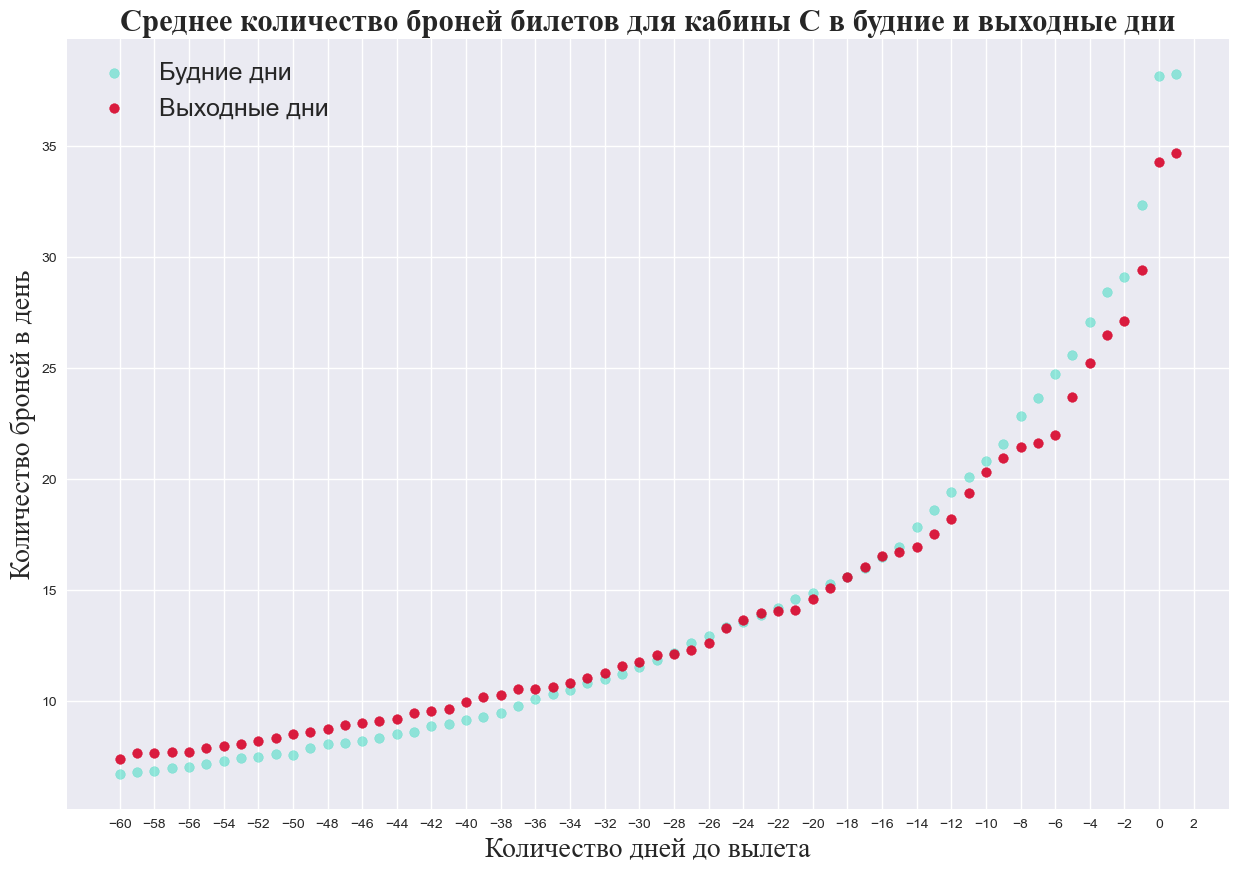

In [148]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(weekdays_C.index, weekdays_C.values, alpha=0.4, color='#04d8b2', cmap='viridis',
            label='Будние дни')
plt.scatter(weekends_C.index, weekends_C.values, alpha=0.9, color='#d8042a', cmap='viridis',
            label='Выходные дни')
plt.title("Среднее количество броней билетов для кабины C в будние и выходные дни",
          fontsize=22, fontweight="bold", fontname="Times New Roman")
plt.xlabel("Количество дней до вылета", fontsize=20, fontname="Times New Roman")
plt.ylabel("Количество броней в день", fontsize=20, fontname="Times New Roman")
plt.xticks(range(-60, 3, 2))
plt.style.use("seaborn")
plt.legend(fontsize=18, shadow=True)
plt.show()

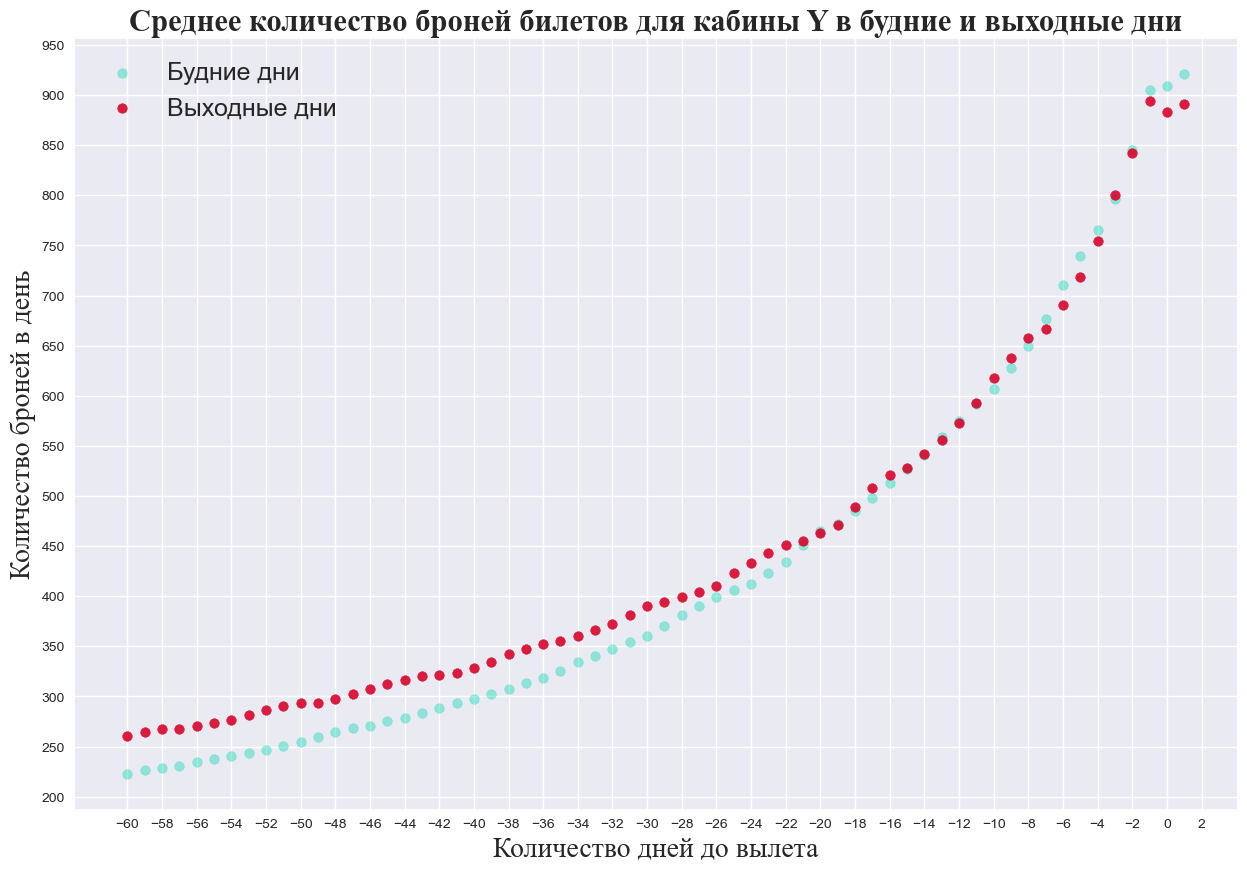

In [150]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(weekdays_Y.index, weekdays_Y.values, alpha=0.4, color='#04d8b2', cmap='viridis',
            label='Будние дни')
plt.scatter(weekends_Y.index, weekends_Y.values, alpha=0.9, color='#d8042a', cmap='viridis',
            label='Выходные дни')
plt.title("Среднее количество броней билетов для кабины Y в будние и выходные дни",
          fontsize=22, fontweight="bold", fontname="Times New Roman")
plt.xlabel("Количество дней до вылета", fontsize=20, fontname="Times New Roman")
plt.ylabel("Количество броней в день", fontsize=20, fontname="Times New Roman")
plt.xticks(range(-60, 3, 2))
plt.yticks(range(200, 951, 50))
plt.style.use("seaborn")
plt.legend(fontsize=18, shadow=True)
plt.show()

Кабина Y бронируется в большем количестве по сравнению с C из-за разницы цен билетов.

# Распределение бронирования билетов по всем дням недели

In [158]:
monday = hh[hh['dayOfWeek'] == 0]
tuesday = hh[hh['dayOfWeek'] == 1]
wednesday = hh[hh['dayOfWeek'] == 2]
thursday = hh[hh['dayOfWeek'] == 3]
friday = hh[hh['dayOfWeek'] == 4]
saturday = hh[hh['dayOfWeek'] == 5]
sunday = hh[hh['dayOfWeek'] == 6]

monday_C = mean_sums(monday[monday['SSCL1'] == C][['DD', 'PASS_BK', 'DTD']])
tuesday_C = mean_sums(tuesday[tuesday['SSCL1'] == C][['DD', 'PASS_BK', 'DTD']])
wednesday_C = mean_sums(wednesday[wednesday['SSCL1'] == C][['DD', 'PASS_BK', 'DTD']])
thursday_C = mean_sums(thursday[thursday['SSCL1'] == C][['DD', 'PASS_BK', 'DTD']])
friday_C = mean_sums(friday[friday['SSCL1'] == C][['DD', 'PASS_BK', 'DTD']])
saturday_C = mean_sums(saturday[saturday['SSCL1'] == C][['DD', 'PASS_BK', 'DTD']])
sunday_C = mean_sums(sunday[sunday['SSCL1'] == C][['DD', 'PASS_BK', 'DTD']])

monday_Y = mean_sums(monday[monday['SSCL1'] == Y][['DD', 'PASS_BK', 'DTD']])
tuesday_Y = mean_sums(tuesday[tuesday['SSCL1'] == Y][['DD', 'PASS_BK', 'DTD']])
wednesday_Y = mean_sums(wednesday[wednesday['SSCL1'] == Y][['DD', 'PASS_BK', 'DTD']])
thursday_Y = mean_sums(thursday[thursday['SSCL1'] == Y][['DD', 'PASS_BK', 'DTD']])
friday_Y = mean_sums(friday[friday['SSCL1'] == Y][['DD', 'PASS_BK', 'DTD']])
saturday_Y = mean_sums(saturday[saturday['SSCL1'] == Y][['DD', 'PASS_BK', 'DTD']])
sunday_Y = mean_sums(sunday[sunday['SSCL1'] == Y][['DD', 'PASS_BK', 'DTD']])

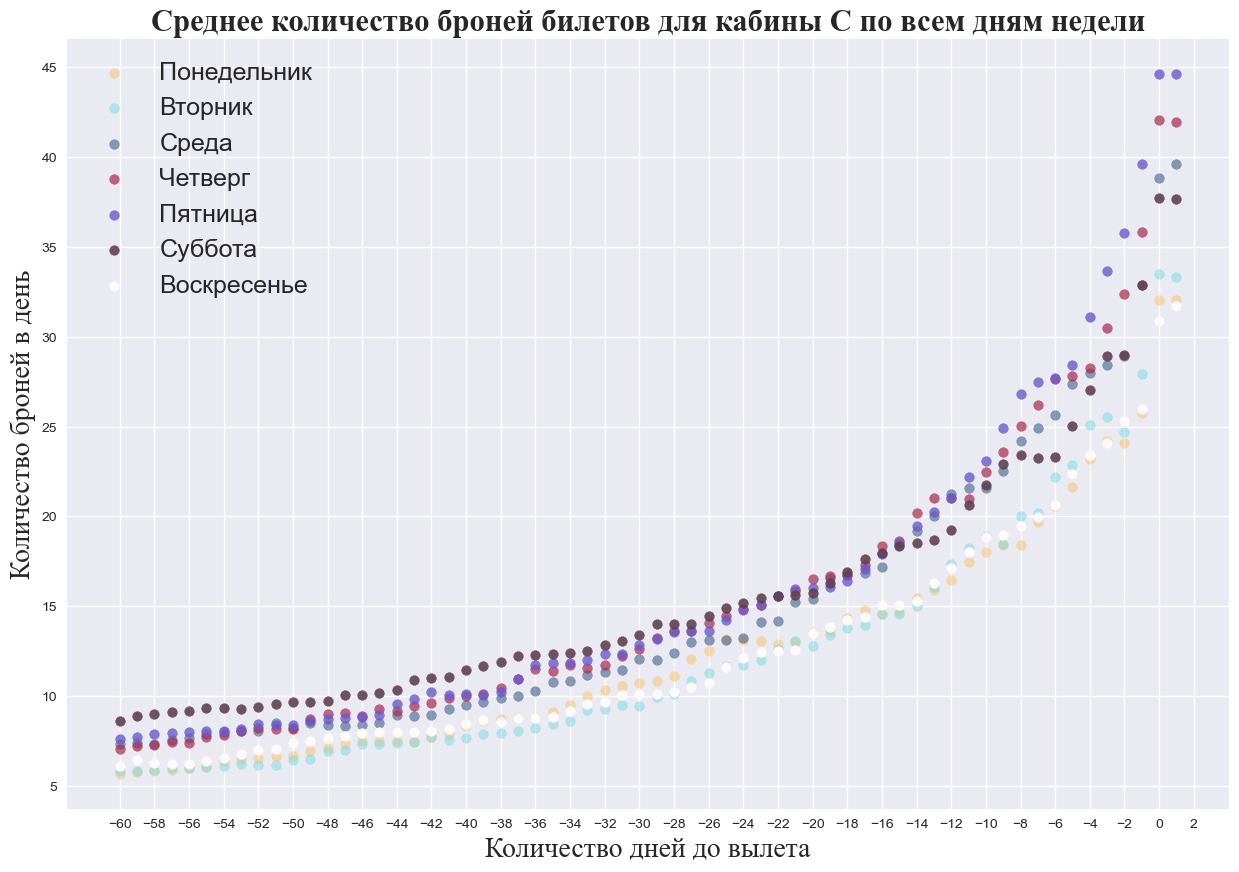

In [165]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(monday_C.index, monday_C.values, alpha=0.4, color='#FFB841', label='Понедельник')
plt.scatter(tuesday_C.index, tuesday_C.values, alpha=0.5, color='#78DBE2', label='Вторник')
plt.scatter(wednesday_C.index, wednesday_C.values, alpha=0.6, color='#3E5F8A', label='Среда')
plt.scatter(thursday_C.index, thursday_C.values, alpha=0.7, color='#AB274F', label='Четверг')
plt.scatter(friday_C.index, friday_C.values, alpha=0.8, color='#6A5ACD', label='Пятница')
plt.scatter(saturday_C.index, saturday_C.values, alpha=0.9, color='#614051', label='Суббота')
plt.scatter(sunday_C.index, sunday_C.values, alpha=1., color='#FFFAFA', label='Воскресенье')
plt.title("Среднее количество броней билетов для кабины C по всем дням недели",
          fontsize=22, fontweight="bold", fontname="Times New Roman")
plt.xlabel("Количество дней до вылета", fontsize=20, fontname="Times New Roman")
plt.ylabel("Количество броней в день", fontsize=20, fontname="Times New Roman")
plt.xticks(range(-60, 3, 2))
plt.style.use("seaborn")
plt.legend(fontsize=18, shadow=True)
plt.show()

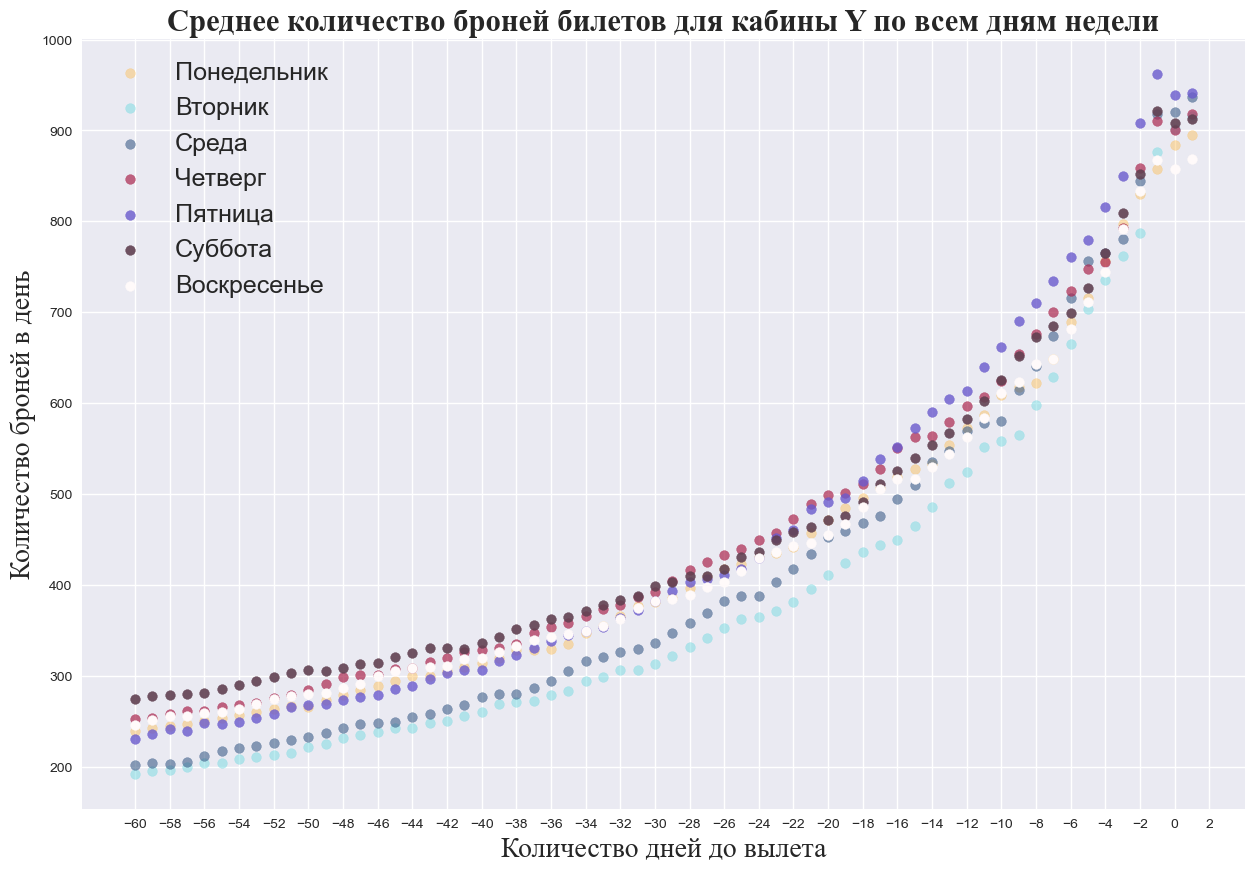

In [166]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(monday_Y.index, monday_Y.values, alpha=0.4, color='#FFB841', label='Понедельник')
plt.scatter(tuesday_Y.index, tuesday_Y.values, alpha=0.5, color='#78DBE2', label='Вторник')
plt.scatter(wednesday_Y.index, wednesday_Y.values, alpha=0.6, color='#3E5F8A', label='Среда')
plt.scatter(thursday_Y.index, thursday_Y.values, alpha=0.7, color='#AB274F', label='Четверг')
plt.scatter(friday_Y.index, friday_Y.values, alpha=0.8, color='#6A5ACD', label='Пятница')
plt.scatter(saturday_Y.index, saturday_Y.values, alpha=0.9, color='#614051', label='Суббота')
plt.scatter(sunday_Y.index, sunday_Y.values, alpha=1., color='#FFFAFA', label='Воскресенье')
plt.title("Среднее количество броней билетов для кабины Y по всем дням недели",
          fontsize=22, fontweight="bold", fontname="Times New Roman")
plt.xlabel("Количество дней до вылета", fontsize=20, fontname="Times New Roman")
plt.ylabel("Количество броней в день", fontsize=20, fontname="Times New Roman")
plt.xticks(range(-60, 3, 2))
plt.style.use("seaborn")
plt.legend(fontsize=18, shadow=True)
plt.show()

# Распределение бронирования билетов по праздничным/не праздничным дням

In [168]:
ordinary = hh[hh['holidays'] == 0]
holidays = hh[hh['holidays'] == 1]
C, Y = 'C', 'Y'
ordinary_C = mean_sums(ordinary[ordinary['SSCL1'] == C][['DD', 'PASS_BK', 'DTD']])
ordinary_Y = mean_sums(ordinary[ordinary['SSCL1'] == Y][['DD', 'PASS_BK', 'DTD']])
holidays_C = mean_sums(holidays[holidays['SSCL1'] == C][['DD', 'PASS_BK', 'DTD']])
holidays_Y = mean_sums(holidays[holidays['SSCL1'] == Y][['DD', 'PASS_BK', 'DTD']])

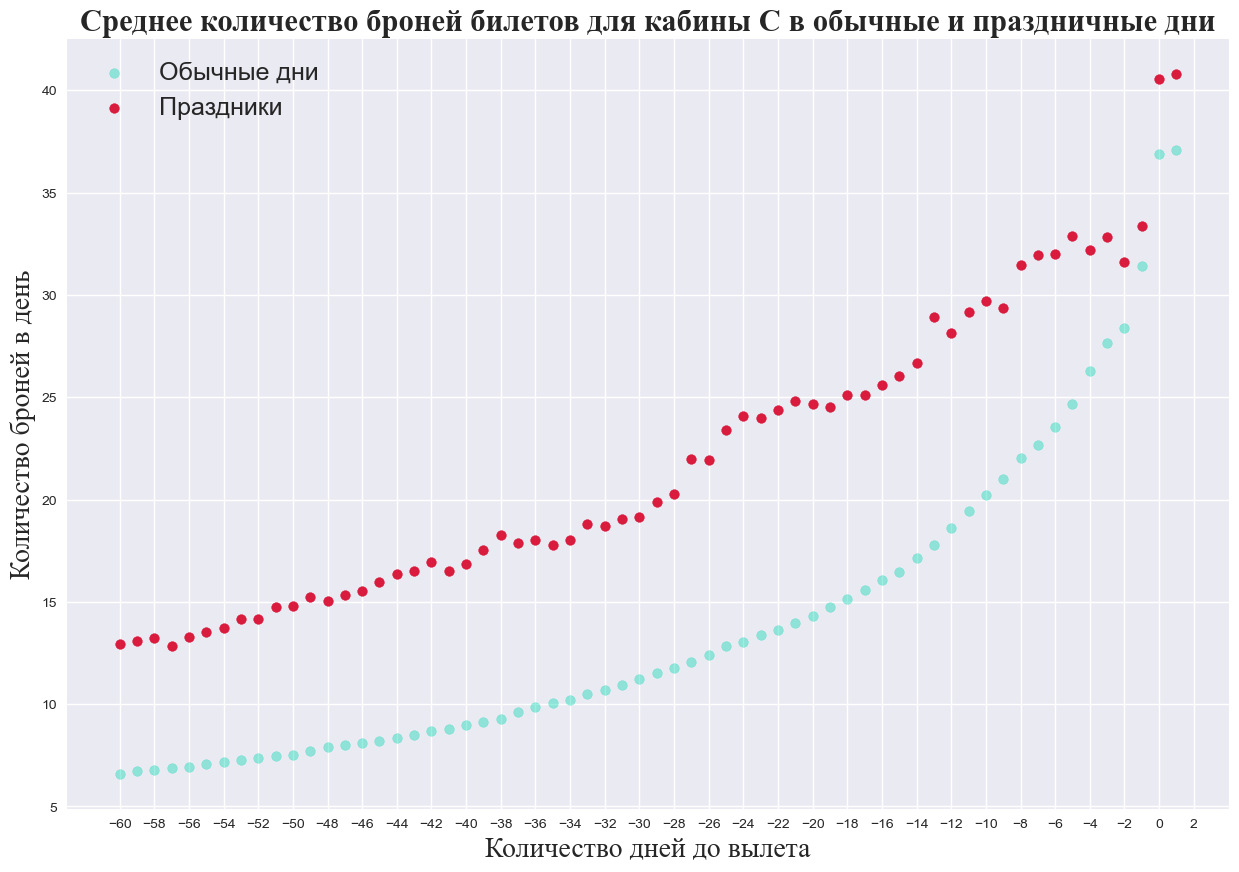

In [170]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(ordinary_C.index, ordinary_C.values, alpha=0.4, color='#04d8b2', label='Обычные дни')
plt.scatter(holidays_C.index, holidays_C.values, alpha=0.9, color='#d8042a', label='Праздники')
plt.title("Среднее количество броней билетов для кабины C в обычные и праздничные дни",
          fontsize=22, fontweight="bold", fontname="Times New Roman")
plt.xlabel("Количество дней до вылета", fontsize=20, fontname="Times New Roman")
plt.ylabel("Количество броней в день", fontsize=20, fontname="Times New Roman")
plt.xticks(range(-60, 3, 2))
plt.style.use("seaborn")
plt.legend(fontsize=18, shadow=True)
plt.show()

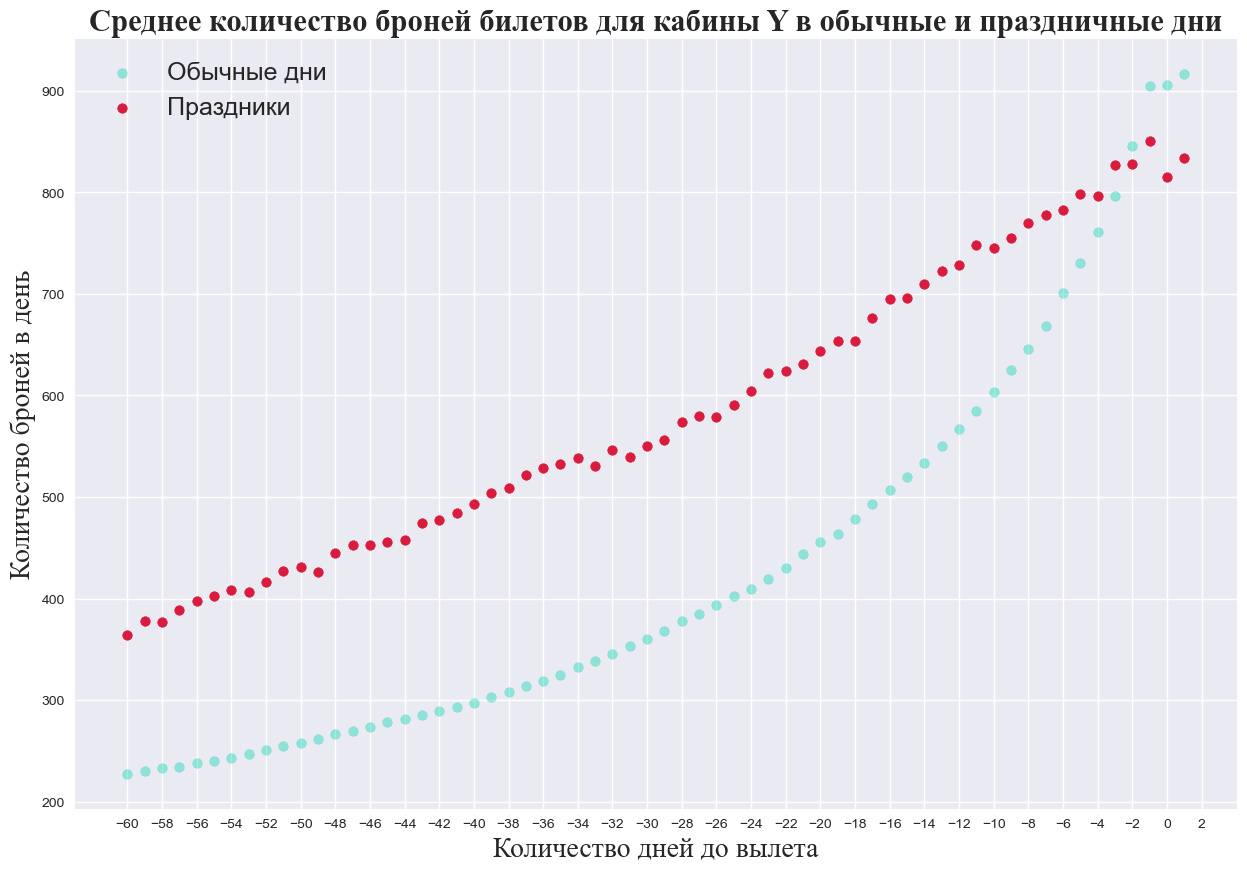

In [171]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(ordinary_Y.index, ordinary_Y.values, alpha=0.4, color='#04d8b2', label='Обычные дни')
plt.scatter(holidays_Y.index, holidays_Y.values, alpha=0.9, color='#d8042a', label='Праздники')
plt.title("Среднее количество броней билетов для кабины Y в обычные и праздничные дни",
          fontsize=22, fontweight="bold", fontname="Times New Roman")
plt.xlabel("Количество дней до вылета", fontsize=20, fontname="Times New Roman")
plt.ylabel("Количество броней в день", fontsize=20, fontname="Times New Roman")
plt.xticks(range(-60, 3, 2))
plt.style.use("seaborn")
plt.legend(fontsize=18, shadow=True)
plt.show()

# Распределение бронирования билетов по времени вылета

In [99]:
def mean_sums(sub_dataframe: pd.DataFrame) -> pd.Series:
    """Подсчёт усреднённого количества бронирований для всех дней до вылета для времён суток"""
    dtds = {key: [] for key in product(range(0, 4), range(-60, 2))}
    for date in sub_dataframe['DD'].unique():
        sub = sub_dataframe[sub_dataframe['DD'] == date]
        sub = pd.merge(sub, bb, on=['DD'], how='inner')
        sub = sub.groupby(by=['TOD', 'DTD'])['PASS_BK'].sum().to_dict()
        for key in sub:
            dtds[key].append(sub[key])
    return pd.Series(dict(map(lambda k_v: (k_v[0], np.mean(k_v[1])), dtds.items())))

In [100]:
%%time
cabin_C = mean_sums(hh[hh['SSCL1'] == C][['DD', 'PASS_BK', 'DTD']])
cabin_Y = mean_sums(hh[hh['SSCL1'] == Y][['DD', 'PASS_BK', 'DTD']])

Wall time: 18.3 s


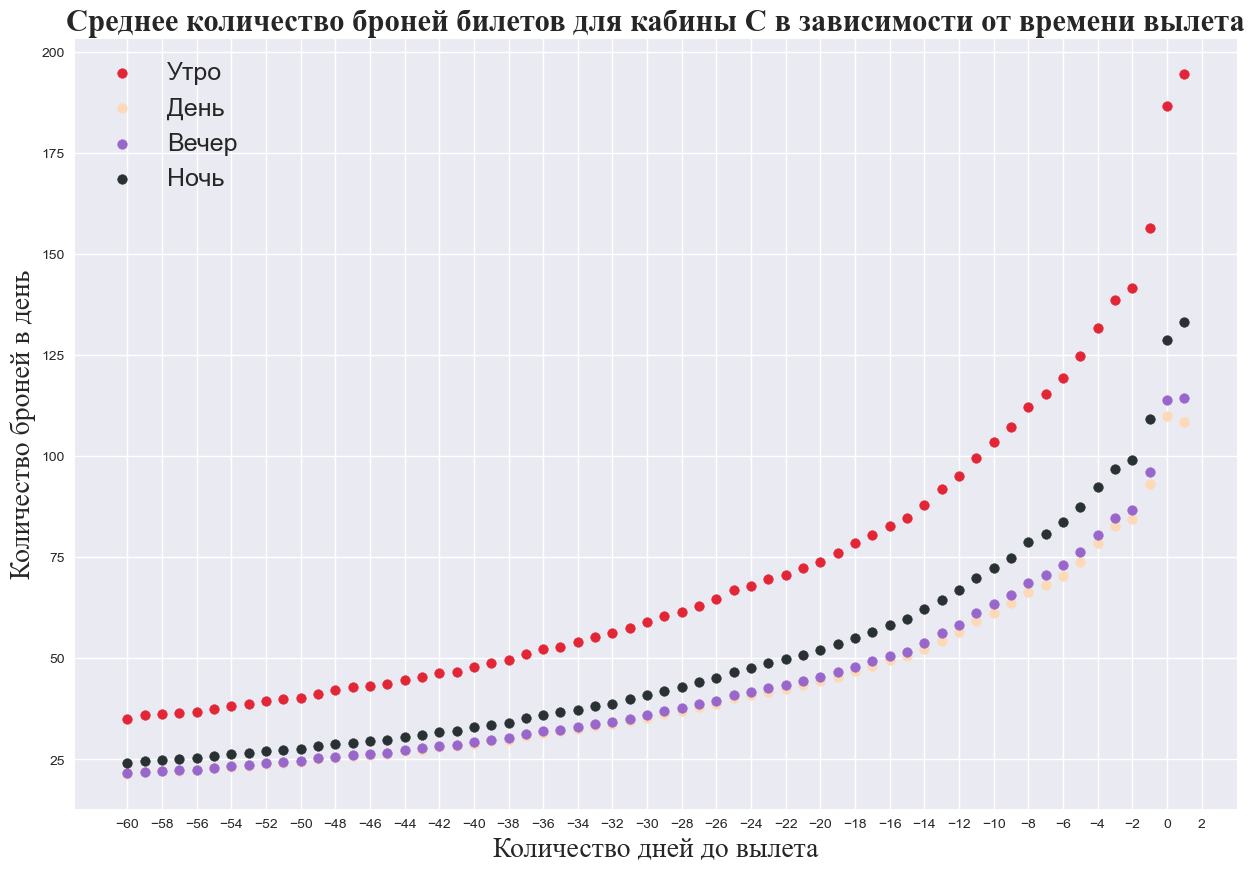

In [103]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(cabin_C[0].index, cabin_C[0].values, color='#E32636', label='Утро')
plt.scatter(cabin_C[1].index, cabin_C[1].values, color='#FDD9B5', label='День')
plt.scatter(cabin_C[2].index, cabin_C[2].values, color='#9966CC', label='Вечер')
plt.scatter(cabin_C[3].index, cabin_C[3].values, color='#293133', label='Ночь')
plt.title("Среднее количество броней билетов для кабины C в зависимости от времени вылета",
          fontsize=22, fontweight="bold", fontname="Times New Roman")
plt.xlabel("Количество дней до вылета", fontsize=20, fontname="Times New Roman")
plt.ylabel("Количество броней в день", fontsize=20, fontname="Times New Roman")
plt.xticks(range(-60, 3, 2))
plt.style.use("seaborn")
plt.legend(fontsize=18, shadow=True)
plt.show()

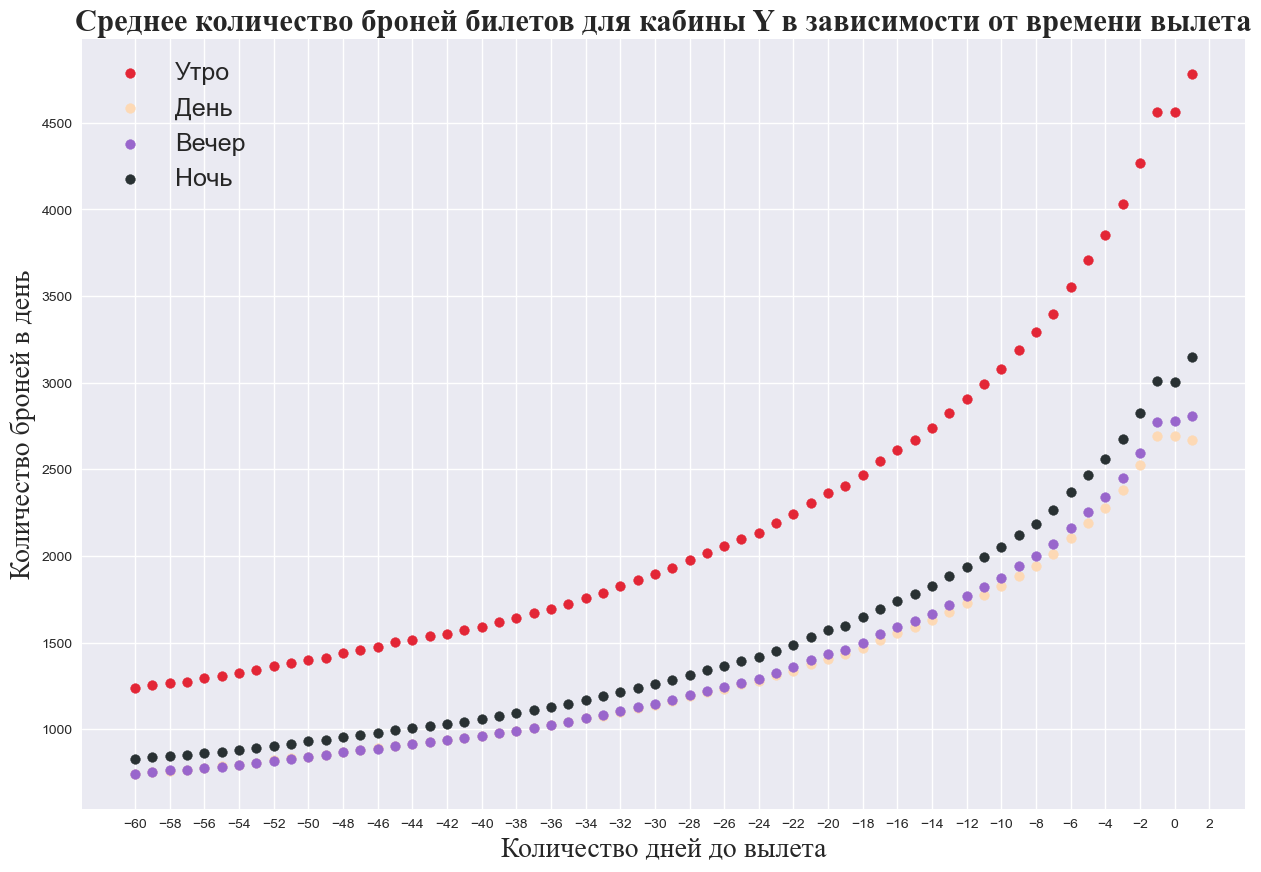

In [105]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(cabin_Y[0].index, cabin_Y[0].values, color='#E32636', label='Утро')
plt.scatter(cabin_Y[1].index, cabin_Y[1].values, color='#FDD9B5', label='День')
plt.scatter(cabin_Y[2].index, cabin_Y[2].values, color='#9966CC', label='Вечер')
plt.scatter(cabin_Y[3].index, cabin_Y[3].values, color='#293133', label='Ночь')
plt.title("Среднее количество броней билетов для кабины Y в зависимости от времени вылета",
          fontsize=22, fontweight="bold", fontname="Times New Roman")
plt.xlabel("Количество дней до вылета", fontsize=20, fontname="Times New Roman")
plt.ylabel("Количество броней в день", fontsize=20, fontname="Times New Roman")
plt.xticks(range(-60, 3, 2))
plt.style.use("seaborn")
plt.legend(fontsize=18, shadow=True)
plt.show()

In [ ]:
dates = ["FLTDAT", "DAIS", "USE_DAT"]
dtypes = {'TARIF_SALE': 'object', 'SALE_CURR': 'object', 'FLTNUM': 'int32'}
bb = pd.read_csv('F:\\' + bb_path, delimiter=';', dtype=dtypes, parse_dates=dates)
bb = bb.dropna(how='any')
bb['TARIF_SALE'] = bb['TARIF_SALE'].astype(float)
bb['FLTTIME'] = pd.to_timedelta(bb['FLTTIME'])
bb[['CPTK', 'TDNR', 'TARIF_RUB', 'TARIF_SALE', 'AIRL', 'COUN', 'KOL_CPN']] = bb[['CPTK', 'TDNR', 'TARIF_RUB', 'TARIF_SALE', 'AIRL', 'COUN', 'KOL_CPN']].astype('float32')

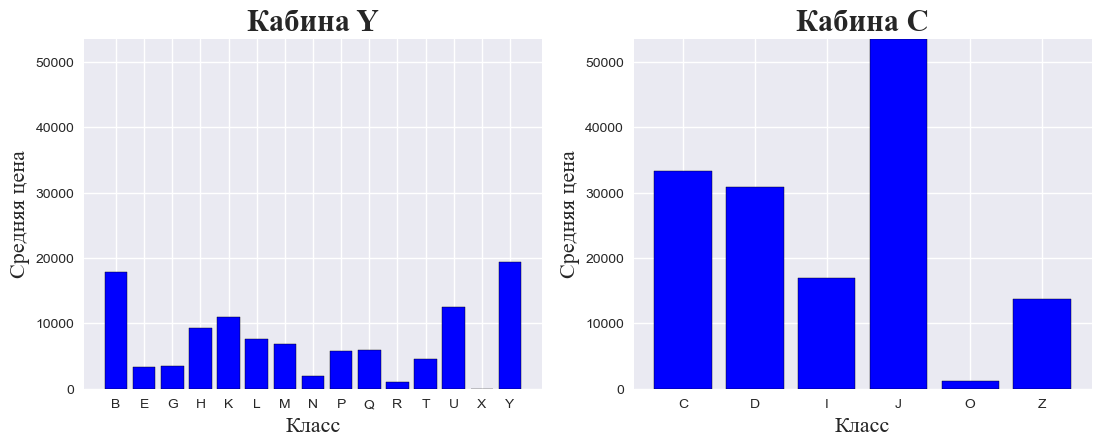

In [49]:
plt.figure(figsize=[13, 10])
mean_price = bb.groupby(by=['BCLS'])['TARIF_RUB'].mean().reset_index()['TARIF_RUB']
plt.subplot(2, 2, 1)
class_y = ['B', 'E', 'G', 'H', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'T', 'U', 'X', 'Y']
class_y_values = mean_price[mean_price.index.isin([0, 3, 4, 5, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19])]
plt.bar(class_y, class_y_values, color='blue', edgecolor='black')
plt.ylabel('Средняя цена', fontsize=16, fontname="Times New Roman")
plt.ylim(min(mean_price), max(mean_price))
plt.xlabel('Класс', fontsize=16, fontname="Times New Roman")
plt.title('Кабина Y', fontsize=22, fontweight="bold", fontname="Times New Roman")
plt.subplot(2, 2, 2)
class_c = ['C', 'D', 'I', 'J', 'O', 'Z']
class_c_values = mean_price[mean_price.index.isin([1, 2, 6, 7, 12, 20])]
plt.bar(class_c, class_c_values, color='blue', edgecolor='black')
plt.ylabel('Средняя цена', fontsize=16, fontname="Times New Roman")
plt.ylim(min(mean_price), max(mean_price))
plt.xlabel('Класс', fontsize=16, fontname="Times New Roman")
plt.title('Кабина C', fontsize=22, fontweight="bold", fontname="Times New Roman")
plt.style.use("seaborn")
plt.show()

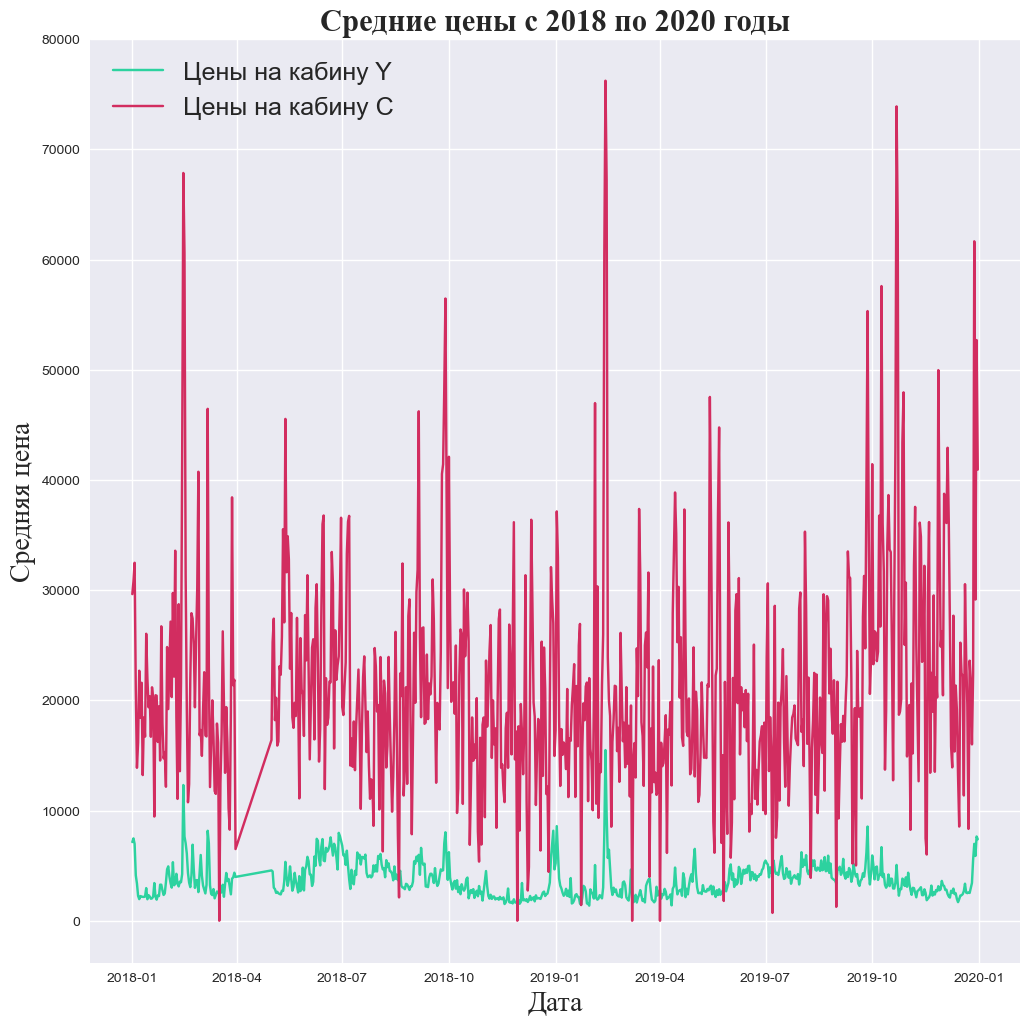

In [51]:
bb['cabin'] = np.where(bb['BCLS'].isin(class_y), 'Y', 'C')
mean_date_Y = bb[bb['cabin'] == 'Y'].groupby(by='FLTDAT')['TARIF_RUB'].mean()
mean_date_С = bb[bb['cabin'] == 'C'].groupby(by='FLTDAT')['TARIF_RUB'].mean()
plt.figure(figsize=[12, 12])
plt.plot(mean_date_Y.index, mean_date_Y.values, color='#2dd29f', label='Цены на кабину Y')
plt.plot(mean_date_С.index, mean_date_С.values, color='#d22d60', label='Цены на кабину С')
plt.ylabel('Средняя цена', fontsize=20, fontname="Times New Roman")
plt.xlabel('Дата', fontsize=20, fontname="Times New Roman")
plt.title('Средние цены с 2018 по 2020 годы', fontsize=22, fontweight="bold", fontname="Times New Roman")
plt.legend(fontsize=18, shadow=True, loc='upper left')
plt.style.use("seaborn")
plt.show()